In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
pd.options.mode.chained_assignment = None  # default='warn'

## Configurations

In [3]:
# rd = 5
# start_week = Week(2021,18)
# end_week = Week(2021,43)
# max_date = datetime.datetime(2021, 6, 23)
# models = ["Ensemble","Ensemble_LOP","IHME-IHME_COVID_model_deaths_unscaled","JHUAPL-Bucky","JHU_IDD-CovidSP","Karlen-pypm",
#           "MOBS_NEU-GLEAM_COVID","UNCC-hierbin","USC-SIkJalpha","UVA-adaptive"]
# # model = "Ensemble"
# model = "MOBS_NEU-GLEAM_COVID"

In [4]:
# rd = 12
# start_week = Week(2022,2)
# end_week = Week(2022,13)
# max_date = datetime.datetime(2022, 3, 15)
# models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
#           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]
# model = models[4]

In [2]:
rd = 14
start_week = Week(2022,23)
end_week = Week(2023,22)
max_date = None
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","MOBS_NEU-GLEAM_COVID_OT","NCSU-COVSIM",
          "UNCC-hierbin","USC-SIkJalpha","USC-SIkJalpha-update","UTA-ImmunoSEIRS","UVA-adaptive"]
# model = "MOBS_NEU-GLEAM_COVID"
model = "Ensemble"

In [4]:
target = 'death'
# target = 'hosp'
incidence = True
target_location = 'US' #only works for the US here
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
locations = locations[locations['location'] != 'US']
locations['location'] = locations['location'].astype(int)
location_mapping = dict()
for loc in locations['location']:
    location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]

## Pull surveillance data

In [5]:
if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target
observations = Observations(pd.read_csv(f"./dat/truth_{start_week.isoformat()}_{end_week.isoformat()}_{'inc' if incidence else 'cum'}_{target_obs}_national.csv",
                               parse_dates=['date']), other_ind_cols=[])
if max_date:
    observations = observations.filter(observations[observations.t_col] <= max_date)

## Load and filter a single model

In [6]:
target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]

In [7]:
predictions = pd.read_csv(f'./dat/smh/rd{rd}/{model}.csv',dtype={'location':str},parse_dates=['target_end_date'])

In [8]:
#filter
predictions_nat = predictions[(predictions['location'] == 'US') & (predictions['target'].isin(target_prediction_list))]
predictions_state = predictions[(predictions['location'] != 'US') & (predictions['target'].isin(target_prediction_list))]
predictions_state['location'] = predictions_state['location'].astype(int)
predictions_state = predictions_state.merge(locations, how='inner', on='location')

In [9]:
#choose location
if target_location == 'US':
    pred = predictions_nat.copy()
else:
    pred = predictions_state[predictions_state['location'] == target_location].copy()   

#filter max date
if max_date:
    pred = pred[pred['target_end_date'] <= max_date]
    
if len(pred) == 0:
    raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

Split by scenarios

In [10]:
scenarios = list(pred['scenario_id'].drop_duplicates())
predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
med_ensemble_predictions = median_ensemble(predictions_list)
ex_ensemble_predictions = extreme_ensemble(predictions_list)
predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme aggregate"]
# print(labels)

## Plot

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
#intervals to show
intervals = [(0.01,0.99),(0.05,0.95),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)

In [12]:
fontsize=14
plt.style.use('seaborn-paper')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}\usepackage{sfmath}')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rc('axes', labelsize=fontsize)
color = '#17B1BF'

### Scenarios

In [13]:
target_loc_name = 'US' if target_location == 'US' else location_mapping[target_location]

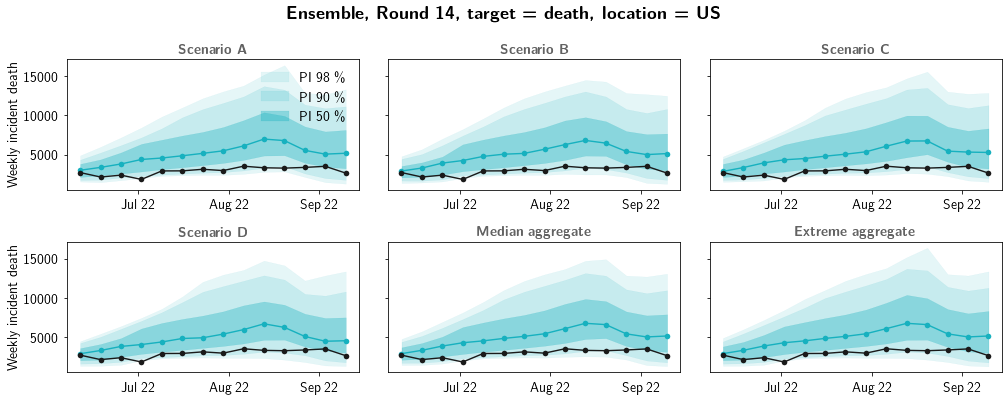

In [14]:
width = 7.057*2.
height = width/2.5
fig, axes = plt.subplots(2,3, figsize=(width, height), sharey=True)
plt.subplots_adjust(left=0.07, bottom=0.08, right=0.99, top=0.85, wspace=0.1,
                    hspace=0.4)
fig.suptitle(r"\textbf"+"{"+f"{model}, Round {rd}, target = {target_obs}, location = {target_loc_name}"+"}", fontsize=fontsize+4)
for ind,(predictions,label) in enumerate(zip(predictions_list,labels)):
    i = ind // 3
    j = ind % 3
    
    #title
    axes[i][j].set_title(r"\textbf"+"{"+f"{label}"+"}", fontsize=fontsize, color='#636363')

    t = np.unique(predictions.get_t())

    #intervals
    for interval in intervals:
        q_low,q_upp = interval
        interval_range = q_upp - q_low
        alpha = map_alpha(interval_range)
        pred_low = predictions.get_quantile(q_low)
        pred_upp = predictions.get_quantile(q_upp)
        axes[i][j].fill_between(t,pred_upp,pred_low, color=color, alpha=alpha,
                               label=fr"PI {int(round(interval_range*100))} \%")
    if i == 0 and j == 0:
        axes[i][j].legend(frameon=True, fontsize=fontsize)

    #point estimate
    pred_point = predictions.get_point()
    if len(pred_point) > 0:
        axes[i][j].plot(t,pred_point,'-o',color=color)
    
    #plot surveillance
    axes[i][j].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a')
    
    #set x axis
    set_date_axis_fmt(axes[i][j])
    

    #set y axis 
    axes[i][0].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} {target}")
    
    
path = f"./figs/smh/rd{rd}/{'inc' if incidence else 'cum'}_{target}/{target_loc_name}/"
Path(path).mkdir(parents=True, exist_ok=True)

plt.savefig(path+f"{model}.pdf")
# plt.savefig(f"./figs/smh/rd{rd}/{model}_{'inc' if incidence else 'cum'}_{target}.pdf")

## Calculate scores

In [15]:
from collections import defaultdict

In [16]:
timestamped_scores = dict()
aggregated_scores = dict()
for label,predictions in zip(labels,predictions_list):
    d,df = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
    timestamped_scores[label] = df
    aggregated_scores[label] = d

In [17]:
aggregated_data = defaultdict(list)
for label in labels:
    aggregated_data['Case'] += [label]
    aggregated_data['95% PI Coverage'] += [aggregated_scores[label]['95_cov']]
    aggregated_data['50% PI Coverage'] += [aggregated_scores[label]['50_cov']]
    aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
    aggregated_data['MAE'] += [aggregated_scores[label]['point_absolute_error_mean']]
    aggregated_data['WIS dispersion %'] += [100*aggregated_scores[label]['dispersion_wis_fraction']]
    aggregated_data['WIS underprediction %'] += [100*aggregated_scores[label]['underprediction_wis_fraction']]
    aggregated_data['WIS overprediction %'] += [100*aggregated_scores[label]['overprediction_wis_fraction']]

In [18]:
agg_data_df = pd.DataFrame(aggregated_data)
agg_data_df['Model'] = model
agg_data_df

,Case,95% PI Coverage,50% PI Coverage,WIS,MAE,WIS dispersion %,WIS underprediction %,WIS overprediction %,Model
0,Scenario A,0.928571,0.142857,1284.436257,2102.751665,48.035141,51.964859,0.0,Ensemble
1,Scenario B,0.928571,0.142857,1210.440707,2091.409129,48.095528,51.904472,0.0,Ensemble
2,Scenario C,0.928571,0.142857,1257.891363,2067.579776,48.397284,51.602716,0.0,Ensemble
3,Scenario D,0.928571,0.214286,1138.582039,1846.632573,49.888427,50.111573,0.0,Ensemble
4,Median aggregate,0.928571,0.142857,1226.494288,2039.309775,48.590886,51.409114,0.0,Ensemble
5,Extreme aggregate,0.928571,0.214286,1230.196638,2039.309775,53.296688,46.703312,0.0,Ensemble
